In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fitting Linear Models with Numpy

Notebook by Joseph E. Gonzalez, Alvin Wan

In this notebook we briefly review the normal equations, evaluation metrics, and describe methods to visualize model fit. **Our goal is to predict average movement speed at a given a time and place.**

Given a model of the form: 

$$
\hat{\mathbb{Y}} = f_\theta(\mathbb{X}) = \mathbb{X} \theta
$$

and taking the average squared loss over our data:

$$
R(\theta) = \frac{1}{n}\sum_{i=1}^n \left(\mathbb{Y}_i - (\mathbb{X}\theta)_i\right)^2
$$

In lecture, we showed that the $\hat{\theta}$ that minimizes this loss:

$$
\hat{\theta} = \arg\min_\theta R(\theta)
$$

is given by the solution to the normal equations:

$$
 \hat{\theta} = \left( \mathbb{X}^T \mathbb{X} \right)^{-1} \mathbb{X}^T \mathbb{Y}
$$

We will use numpy to compute and use this theta below.

Notebook by Joseph E. Gonzalez, Alvin Wan

# 1. Load Uber Movement Speeds Dataset

To enable easy visualization of the model fitting process we will use a simple traffic speeds dataset, provided by Uber at https://movement.uber.com/cities/san_francisco/downloads/speeds?lang=en-US

In [11]:
df = pd.read_csv("./data/movement-speeds.csv")
df.head()

,Unnamed: 0,day,hour,osm_way_id,speed_mph_mean,speed_mph_stddev,Latitude,Longitude
0,0,4,11,515486318,10.127,8.503,37.779522,-122.406901
1,1,1,12,515486318,11.217,9.453,37.779522,-122.406901
2,2,2,23,515486318,12.924,11.087,37.779522,-122.406901
3,3,1,0,515486318,13.827,9.969,37.779522,-122.406901
4,4,5,1,515486318,14.770,12.378,37.779522,-122.406901


Compute an absolute time reference, using the day and hour. Times will start at 0--representing March 1, 2020 12-1 AM--incrementing by 1 at a time until 192--representing March 8, 2020 11 PM - 12 AM.

In [12]:
df['time'] = (df['day'] - 1) * 24 + df['hour']
df = df.sort_values(by='time')
df.head()

,Unnamed: 0,day,hour,osm_way_id,speed_mph_mean,speed_mph_stddev,Latitude,Longitude,time
116977,116977,1,0,598020854,17.064,9.101,37.798169,-122.404337,0
121508,121508,1,0,620535183,30.618,5.563,37.893175,-122.530579,0
28117,28117,1,0,184255666,8.885,9.945,37.711521,-122.455590,0
121273,121273,1,0,513702094,59.773,6.543,37.732805,-122.404772,0
121178,121178,1,0,394558807,10.600,6.313,37.773167,-122.407792,0


Plot the average movement speed over time, aggregating across all locations.

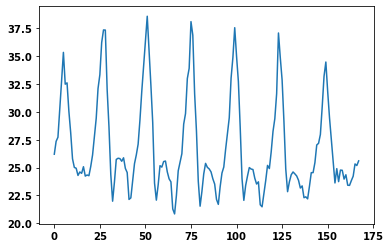

In [13]:
time = df.groupby(by=['time']).agg('mean').reset_index()
plt.plot(time['time'], time['speed_mph_mean'])

Now we see that on average, across all streets, speeds are roughly periodic. Let's check a random street to see if this holds for individual streets.

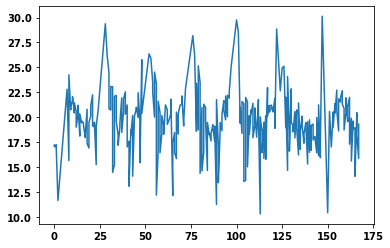

In [14]:
sample = df[df['osm_way_id'] == 598020854]
plt.plot(sample['time'], sample['speed_mph_mean'])

# 2. Fit OLS Model using numpy

## 2.a Solve OLS

We can directly implement this expression using standard linear algebra routines. For now, we will train a naive model that predicts movement speed given only time:

In [15]:
X, Y = df[['time']], df[["speed_mph_mean"]]

In [16]:
from numpy.linalg import inv
theta = inv(X.T @ X) @ X.T @ Y
theta

,speed_mph_mean
0,0.216202


## 2.b Predict with OLS

We can use our $\hat{\theta}$ to make predictions:

$$
\hat{\mathbb{Y}} = \mathbb{X} \hat{\theta}
$$

In [17]:
df["Yhat"] = X @ theta.to_numpy()
df

,Unnamed: 0,day,hour,osm_way_id,speed_mph_mean,speed_mph_stddev,Latitude,Longitude,time,Yhat
116977,116977,1,0,598020854,17.064,9.101,37.798169,-122.404337,0,0.000000
121508,121508,1,0,620535183,30.618,5.563,37.893175,-122.530579,0,0.000000
28117,28117,1,0,184255666,8.885,9.945,37.711521,-122.455590,0,0.000000
121273,121273,1,0,513702094,59.773,6.543,37.732805,-122.404772,0,0.000000
121178,121178,1,0,394558807,10.600,6.313,37.773167,-122.407792,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
13070,13070,7,23,32929983,25.072,4.717,37.767946,-122.425559,167,36.105756
128232,128232,7,23,158602255,12.814,4.462,37.771837,-122.481757,167,36.105756
35056,35056,7,23,530592670,18.134,3.869,37.764794,-122.424052,167,36.105756
17504,17504,7,23,89802405,17.917,4.076,37.757981,-122.476769,167,36.105756


## 2.c Evaluate OLS

How good are our predictions? We can plot $Y$ vs $\hat{Y}$

In [18]:
def plot_y_vs_yhat(df, y, yhat):
    plt.figure()
    Y, Yhat = df[y], df[yhat]
    plt.scatter(Yhat, Y, label='(yhat, y)')
    cmin, cmax = max(Yhat.min(), Y.min()), min(Yhat.max(), Y.max())
    plt.plot([cmin, cmax], [cmin, cmax], color='red', label='y=yhat')
    plt.legend()

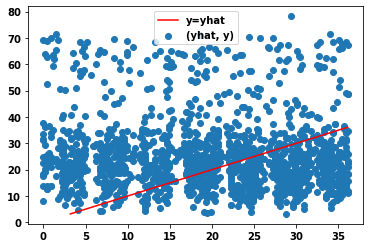

In [19]:
plot_y_vs_yhat(df.sample(frac=0.01), y="speed_mph_mean", yhat="Yhat")

We can also plot the distribution of residuals, or $\mathbb{Y}_i - \hat{\mathbb{Y}}_i$

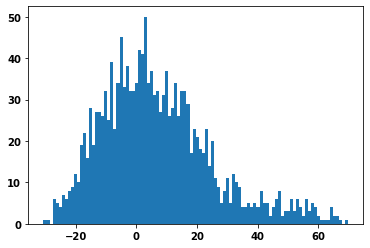

In [20]:
df['residuals'] = df['speed_mph_mean'] - df['Yhat']
_ = plt.hist(df.sample(frac=0.01)['residuals'], bins=100)

The bulk of your residuals lie between [-15, 20], qualitatively speaking. To quantify this, we'll compute the average squared loss, or $R(\theta)$ as defined above.

In [21]:
(df['residuals'] ** 2.).mean()

345.75991698324754

To understand how to improve this error, let's visualize our predictions.

## 4. Visualize OLS Predictions

Let's visualize the predictions along the time dimension.

In [22]:
def plot_predictions(df, x, y, yhat):
    plt.figure()
    X, Y, Yhat = df[x], df[y], df[yhat]
    plt.plot(X, Y, label='ground truth')
    plt.plot(X, Yhat, label='prediction')
    plt.legend()

In [23]:
def plot_predictions_over_time(df, x, y, yhat):
    time = df.groupby(by='time').agg('mean').reset_index()
    plot_predictions(time, x, y, yhat)

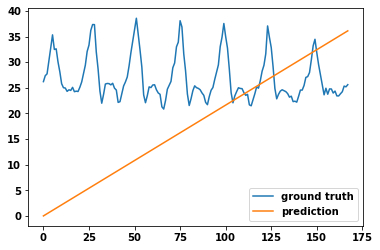

In [24]:
plot_predictions_over_time(df, x='time', y='speed_mph_mean', yhat='Yhat')

Notice that the plane is constrained to pass through the origin.  To fix this, we will need to add a constant term to the model.

# 3. Fit Biased OLS

Adding a constant term $c$ to our model, we get

$$
\hat{\mathbb{Y}} = f_\theta(\mathbb{X}) = \mathbb{X} \theta + b
$$

Note we can write out the following equivalence:

$$
\mathbb{X} \theta + c = [\mathbb{X}, 1]\begin{bmatrix}\theta \\ b\end{bmatrix} = \phi(\mathbb{X}) \theta_2
$$

where $\theta_2 = [\theta, b]$ and $\phi(\mathbb{X}) = [\mathbb{X}, 1]$. Since $b$ and $\theta$ are both model weights, we can simply define a new $\theta_2$. We also define $\phi(\mathbb{X})$ to be the original data matrix $\mathbb{X}$, except with a column of constant 1s.

In [25]:
def phi(X):
    return np.hstack([
        X,
        np.ones((X.shape[0], 1))
    ])

In [26]:
phi(X) # construct \phi(X), which is the original data matrix X, with a column of constant 1s

array([[  0.,   1.],
       [  0.,   1.],
       [  0.,   1.],
       ...,
       [167.,   1.],
       [167.,   1.],
       [167.,   1.]])

## 3.a Solve Biased OLS

We can solve this least squares problem just like we did before.

In [27]:
theta2 = inv(phi(X).T @ phi(X)) @ phi(X).T @ Y
theta2

,speed_mph_mean
0,-0.010320
1,26.047099


## 3.b Predict with Biased OLS

Make predictions like we did before. Notice we have to featurize X here with $\phi$ as well.

In [28]:
df["Yhat2"] = phi(X) @ theta2.to_numpy()
df.head()

,Unnamed: 0,day,hour,osm_way_id,speed_mph_mean,speed_mph_stddev,Latitude,Longitude,time,Yhat,residuals,Yhat2
116977,116977,1,0,598020854,17.064,9.101,37.798169,-122.404337,0,0.0,17.064,26.047099
121508,121508,1,0,620535183,30.618,5.563,37.893175,-122.530579,0,0.0,30.618,26.047099
28117,28117,1,0,184255666,8.885,9.945,37.711521,-122.455590,0,0.0,8.885,26.047099
121273,121273,1,0,513702094,59.773,6.543,37.732805,-122.404772,0,0.0,59.773,26.047099
121178,121178,1,0,394558807,10.600,6.313,37.773167,-122.407792,0,0.0,10.600,26.047099


## 3.c Evaluate Biased OLS

Check your Yhat-vs-Y plot.

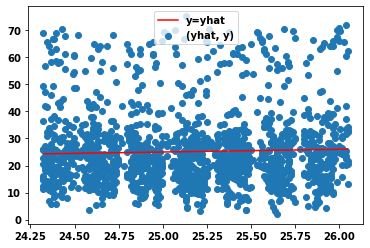

In [29]:
plot_y_vs_yhat(df.sample(frac=0.01), y="speed_mph_mean", yhat="Yhat2")

Still looks qualitatively bad. Check your residuals.

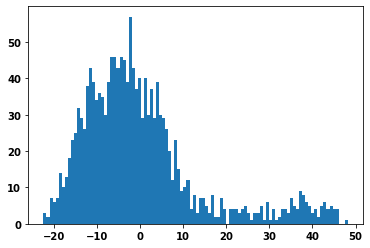

In [30]:
df['residuals2'] = df['speed_mph_mean'] - df['Yhat2']
_ = plt.hist(df.sample(frac=0.01)['residuals2'], bins=100)

Notice the bulk of your residuals now lie between [-10, 5], qualitatively much better than the previous model's residuals. Let's quantify this again, like before.

In [31]:
(df['residuals2'] ** 2.).mean()

186.94520321966797

Much better: Our error before was 345. At 186, this is a 46% reduction in error! Like before, let's now visualize the model's predictions. Summary of our results so far:

||MSE|
|---|---|
|**OLS**|346|
|**Biased OLS**|187|

## 3.d Visualize Biased OLS Predictions

Replot your new predictions.

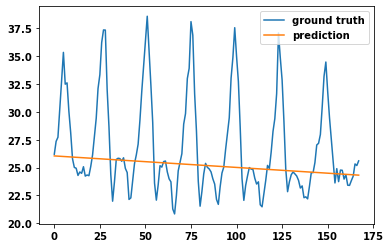

In [32]:
plot_predictions_over_time(df, x='time', y='speed_mph_mean', yhat='Yhat2')

Looks great! Our new predictions (in green) much more closely match the data. To simplify the process let's switch to using the scikit-learn python library for our modeling.

# Appendix A

Random stuff I ended up removing from lecture material.

We can visualize the data in three dimensions:

In [33]:
import plotly.express as px

In [34]:
# prettier plotly plots
time = df.groupby(by=['time']).agg('mean').reset_index()
px.line(time, x='time', y='speed_mph_mean')

In [35]:
sample = df[df['osm_way_id'] == 598020854]
px.line(sample, x='time', y='speed_mph_mean')

In [36]:
# prettier plotly plots
def plot_y_vs_yhat(df, y, yhat):
    Y, Yhat = df[y], df[yhat]
    cmin, cmax = max(Yhat.min(), Y.min()), min(Yhat.max(), Y.max())
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=Yhat, y=Y, mode='markers', name='(yhat, y)'))
    fig.add_trace(go.Scatter(x=[cmin,cmax], y=[cmin,cmax], name="y=yhat"))
    return fig

In [37]:
# prettier plotly plots
def plot_predictions(df, x, y, yhat):
    X, Y, Yhat = df[x], df[y], df[yhat]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X, y=Y, name='ground truth'))
    fig.add_trace(go.Scatter(x=X, y=Yhat, name='prediction'))
    return fig

In [38]:
subset = df.sample(frac=0.01)
fig = px.scatter_3d(subset, x='Latitude', y='Longitude', z='speed_mph_mean', color='time')
fig.update_traces(marker={'size': 2})

Looks like total gibberish! Instead of visualizing all 4 dimensions of data, let's break it down. First, let's visualize spatially.

In [39]:
space = df.groupby(by=['Latitude', 'Longitude']).agg('mean').reset_index()
fig = px.scatter_3d(space, x='Latitude', y='Longitude', z='speed_mph_mean')
fig.update_traces(marker={'size': 2})

# Appendix B

A more efficient way to solve the normal equations is using the `solve` function to solve the linear systems:

$$
\mathbb{X}^T \mathbb{X} \theta = \mathbb{X}^T \mathbb{Y}
$$

can be simplified to:

$$
A \theta = b
$$

where $A=\mathbb{X}^T \mathbb{X}$ and $b=\mathbb{X}^T \mathbb{Y}$:

In [40]:
from numpy.linalg import solve
theta = solve(X.T @ X, X.T @ Y)
theta

array([[0.21620213]])

Notice that this second implementation produces a numpy array?  This is because Pandas actually implements inversion but the solve routine is entirely in numpy.